# READ MASS BALANCE DATA FROM OGGM, PYGEM, GLOGEM

In [1]:
# Import libraries
import os
import re
import numpy as np
import xarray as xr
import pandas as pd

## GLOGEM

### Glacier-wide monthly mass balance

In [58]:
filepath_glo_gw = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Data/ML_model_comparison/GloGEM_glacier_wide/RGI08_glacier-wide/RGI08_glacier-wide/'
filename_glo_gw = 'scandinavia_Balance_mon_r1.dat'

In [59]:
# File structure:
# For each row: 1ID + 12 (monthly) values * num_years. The first year starts with month 10, last year ends with month 9, the first column is glacier ID
# File only contains 1 + 41 column names, representing the identifier and the years.
# Need to create new column names corresponding to year and month

id_col = ['ID']
years = range(1981, 2020)  # 1981 - 2019
initial_months_1980 = ['1980_10', '1980_11', '1980_12']
subsequent_months = [f"{year}_{month:02d}" for year in years for month in range(1, 13)]
final_months_2020 = [f"2020_{month:02d}" for month in range(1, 10)]

# Combine all column names
column_names = id_col + initial_months_1980 + subsequent_months + final_months_2020

# Load data, skip first row with old column names
df = pd.read_csv(filepath_glo_gw + filename_glo_gw, delim_whitespace=True,
                 header=None, names=column_names, index_col=False, skiprows=1)


In [60]:
df

,ID,1980_10,1980_11,1980_12,1981_01,1981_02,1981_03,1981_04,1981_05,1981_06,...,2019_12,2020_01,2020_02,2020_03,2020_04,2020_05,2020_06,2020_07,2020_08,2020_09
0,3287,0.0000,0.9559,0.6842,0.3142,0.4000,0.2478,0.3683,-0.2213,-0.8148,...,0.6255,0.4889,0.4616,0.7420,-0.2953,-0.3252,-0.7112,-1.0052,-1.4863,-0.9279
1,2665,-0.2588,1.0097,0.7774,0.3603,0.4295,0.2852,0.4059,-0.3080,-0.7726,...,0.7544,0.6131,0.5424,0.8516,-0.3489,-0.3597,-0.7041,-0.9472,-0.9151,-0.9400
2,2669,0.1749,0.7382,0.5573,0.2583,0.3079,0.2045,0.3291,-0.1345,-0.7181,...,0.5588,0.4403,0.4092,0.6155,-0.2181,-0.2066,-0.6371,-0.9221,-0.8808,-0.6952
3,2660,0.1832,0.6302,0.4758,0.2205,0.2629,0.1746,0.2918,-0.0443,-0.6410,...,0.4771,0.3759,0.3494,0.5255,-0.1312,-0.0292,-0.5600,-0.8439,-0.8014,-0.5560
4,336,0.1757,0.8262,0.6238,0.2891,0.3447,0.2288,0.3628,-0.1871,-0.7551,...,0.6246,0.4928,0.4577,0.6889,-0.2593,-0.2797,-0.6741,-0.9596,-1.0686,-0.7885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3411,2483,0.3128,0.2432,0.3458,0.2675,0.2700,0.1210,0.2393,0.2549,-0.5556,...,0.2513,0.3336,0.3103,0.3644,0.3105,0.2788,-0.3255,-0.6637,-0.6048,-0.3250
3412,2476,0.3199,0.2463,0.3503,0.2709,0.2735,0.1226,0.2433,0.2730,-0.5515,...,0.2546,0.3379,0.3143,0.3691,0.3172,0.3122,-0.3149,-0.6636,-0.6012,-0.3111
3413,3,0.1046,0.1081,0.0910,0.0763,0.0392,0.0660,0.0623,-0.0073,-0.8712,...,0.0607,0.0645,0.1153,0.1060,-0.0012,-0.1885,-0.6308,-1.5916,-1.4324,-0.8067
3414,4,0.1030,0.1074,0.0904,0.0758,0.0390,0.0655,0.0613,-0.0133,-0.8855,...,0.0604,0.0641,0.1146,0.1053,-0.0038,-0.2067,-0.6447,-1.6207,-1.4613,-0.8339


### Elevation-band monthly mass balance

In [65]:
filepath_glo_elevband = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Data/ML_model_comparison/GloGEM_monthly_elevation_bands/mb_elevation_monthly/'
filename_glo_elevband_prefix = 'belev_mon_0'
filename_glo_elevband_suffix = '.dat'


In [66]:
# Folder contains one file per glacier id. Get glacier ids with point mb observations and retrieve only these data.
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate.csv'

# Load data.
data = pd.read_csv(filepath + filename)


C:\Users\kasj\AppData\Local\Temp\ipykernel_17644\1641773205.py:13: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(filepath + filename)


In [67]:
data

,RGIID,GLIMSID,BREID,utm_zone,utm_east_approx,utm_north_approx,altitude_approx,location_description,location_id,stake_no,...,tp_jan,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,altitude_climate
0,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1012,...,0.005081,0.005116,0.002688,0.002334,0.001159,0.003054,0.003977,0.004691,0.001449,341.227919
1,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.000121,0.001831,0.004597,0.005634,0.002244,0.003412,0.000891,0.002129,0.004860,341.227919
2,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001190,0.004949,0.003286,0.003739,0.004709,0.005111,0.001253,0.002506,0.003256,341.227919
3,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1013,...,0.001945,0.002495,0.002263,0.001256,0.002129,0.003969,0.003559,0.002119,0.002851,341.227919
4,RGI60-08.01258,G021737E70130N,54,34,529400.0,7780050.0,500.0,Nederst på bretunga,L10,L1016,...,0.004863,0.003314,0.004417,0.002704,0.003991,0.001780,0.004257,0.005193,0.000710,341.227919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.009134,0.011964,0.007288,0.003555,0.005019,0.004730,0.007226,0.005739,0.011397,917.419759
4167,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1509,...,0.005585,0.002572,0.000807,0.009360,0.006135,0.006760,0.005158,0.008218,0.005461,917.419759
4168,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.017394,0.008543,0.010311,0.006261,0.008175,0.005974,0.006563,0.008015,0.003896,917.419759
4169,RGI60-08.02969,G006362E59989N,3141,32,351800.0,6647500.0,1080.0,Nederst på bretunga,B15,B1514,...,0.007431,0.008916,0.003751,0.004573,0.004449,0.005235,0.008926,0.011151,0.009556,917.419759


In [68]:
# Get list of RGIID from 'RGIID' column using only last four digits of the ID
rgi_ids = data['RGIID'].str[-4:].unique()
rgi_ids_list = rgi_ids.tolist()

rgi_ids_list_sorted = sorted(rgi_ids_list, key=lambda x: int(x))

print(rgi_ids_list_sorted)


['0287', '0295', '0434', '0449', '0868', '0966', '0987', '1013', '1026', '1126', '1186', '1217', '1258', '1286', '1484', '1598', '1657', '1779', '2017', '2384', '2436', '2458', '2643', '2650', '2666', '2916', '2918', '2920', '2962', '2963', '2966', '2969']


In [70]:
# Dict to store DataFrames
dfs = {}

# Loop through list of rgiids and read files
for identifier in rgi_ids_list_sorted:

    filename = f'belev_mon_0{identifier}.dat'
    
    # Read data as DataFrame
    df = pd.read_csv(filepath_glo_elevband + filename, delim_whitespace=True, skiprows=2, header=0)
    
    # Replace -99.000 with NaN
    df.replace(-99.000, np.nan, inplace=True)
    
    # Add DataFrame to dict
    dfs[identifier] = df

data_arrays = []

# Iterate over DataFrames and create dataarray for each
for identifier, df in dfs.items():
    # Use Year+Month as time coordinates and the elevation as 'elevation' dimension
    da = xr.DataArray(df.values[:,3:], coords={'time': pd.to_datetime(df[['Year', 'Month']].assign(day=1)),
                                         'elevation': df.columns[3:].astype(int),
                                         'ID': identifier},
                      dims=['time', 'elevation'])
    data_arrays.append(da)

# Combine DataArrays to Dataset
ds = xr.concat(data_arrays, dim='ID')

# Set the elevations as non-dimensional coordinate and will with NaNs for glaciers where these elev bands don't exist
ds = ds.reindex(elevation=list(np.unique(np.concatenate([da.elevation.values for da in data_arrays]))), fill_value=np.nan)

print(ds)

<xarray.DataArray (ID: 32, time: 480, elevation: 225)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,

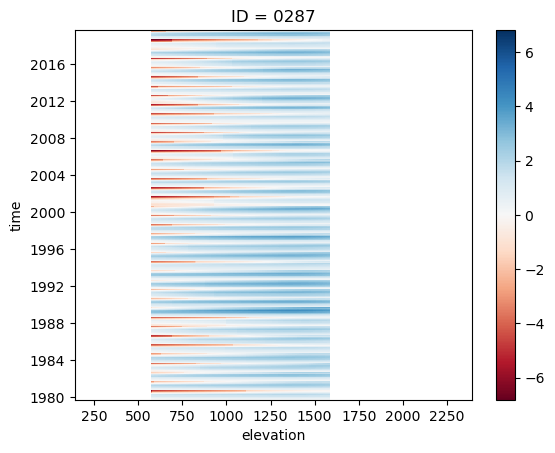

In [71]:
ds[0,:,:].plot(cmap='RdBu')

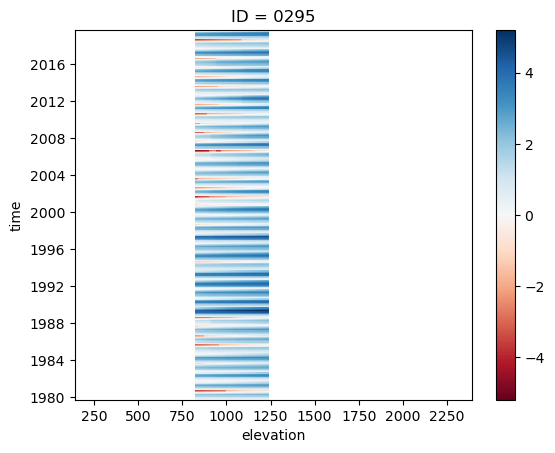

In [72]:
ds[1,:,:].plot(cmap='RdBu')

In [73]:
# Values are cumulative from Oct of each year until september of the following year (cumulative over the hydrological year)
# to get the monthly elevation band value we need to subtract the previous months value (except for october, when a new period starts).
# Calculate the diff along the time dimension to get the monthly values

# Calculate month-to-month differences (monthly mass balance)
diff = ds.diff(dim='time')

# Add to Dataset
diff_padded = xr.concat([ds.isel(time=0).expand_dims('time'), diff], dim='time')

# Identify October - should retain original values
is_october = ds['time'].dt.month == 10

# Create dataarray where values are monthly mb (diff_padded) for all months except October (origional values)
ds_monthly_mb_elevband = xr.where(is_october, ds, diff_padded)

# Set nan for non-existing elevation bands
ds_monthly_mb_elevband = ds_monthly_mb_elevband.where(~np.isnan(ds))

# Reorder dimensions
ds_monthly_mb_elevband = ds_monthly_mb_elevband.transpose('ID', 'time', 'elevation')

print(ds_monthly_mb_elevband)


<xarray.DataArray (ID: 32, time: 480, elevation: 225)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,

In [74]:
# Save monthly elevation-band mass balance as dataset

ds_monthly_mb_elevband_save = ds_monthly_mb_elevband.to_dataset(name='mb_monthly')

filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

#ds_monthly_mb_elevband_save.to_netcdf(filepath_save + 'GloGEM_monthly_mb_elev_band.nc')


### Annual mass balance in each elevation band

In [76]:
# Count nan per 12 month window
non_nan_count = ds_monthly_mb_elevband.coarsen(time=12, boundary='trim').count()

# Aggregate mass balance for each year (12 months)
ds_annual_mb_elevband = ds_monthly_mb_elevband.coarsen(time=12, boundary='trim').sum()

# Insert nan for non-existing elevation bands
ds_annual_mb_elevband = ds_annual_mb_elevband.where(non_nan_count == 12)

# Set hydrological years
hydro_years = pd.date_range(start='1980', end='2020', freq='AS-OCT')

# Set time to hydrological year
ds_annual_mb_elevband['time'] = hydro_years
ds_annual_mb_elevband = ds_annual_mb_elevband.assign_coords(time=hydro_years)

In [77]:
ds_annual_mb_elevband

<xarray.DataArray (ID: 32, time: 40, elevation: 225)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1980-10-01 1981-10-01 ... 2019-10-01
  * elevation  (elevation) int64 145 155 165 175 185 ... 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'

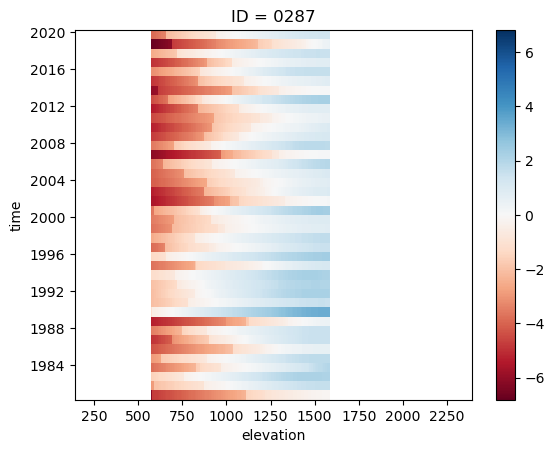

In [78]:
ds_annual_mb_elevband[0,:,:].plot(cmap='RdBu')

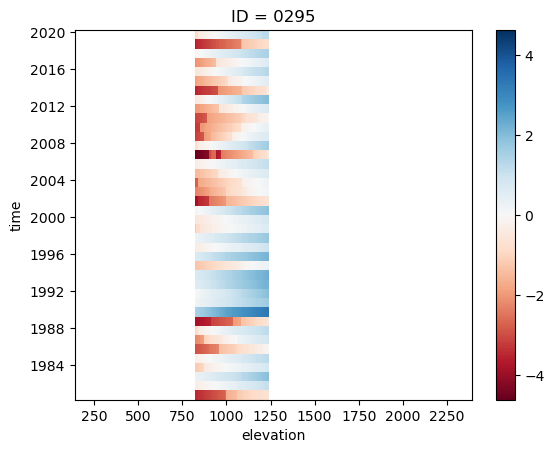

In [79]:
ds_annual_mb_elevband[1,:,:].plot(cmap='RdBu')

### Seasonal mass balance in each elevation band

In [80]:
# Add hydrological year as coordinate in monthly mb dataset
def hydro_year(time):
    year = time.dt.year
    month = time.dt.month
    return year.where(month < 10, year + 1)

# Add a 'hydro_year' coordinate to the dataset
ds_monthly_mb_elevband['hyd_year'] = hydro_year(ds_monthly_mb_elevband['time'])

# Group by hydrological year
grouped = ds_monthly_mb_elevband.groupby('hyd_year')


In [56]:
#ds_monthly_mb_elevband.hyd_year

In [81]:
def select_sum(group, months):
    selected_group = group.sel(time=group['time.month'].isin(months))
    non_nan_count = selected_group.count(dim='time')
    summed_group = selected_group.sum(dim='time')
    return summed_group.where(non_nan_count >= 1)


In [82]:
# Get winter mass balance in elevation bands

# Accumulate monthly data only for months from October to April
winter_months = [10, 11, 12, 1, 2, 3, 4]

ds_winter_mb_elevband = grouped.map(select_sum, args=(winter_months,))

hyd_yr_dates = pd.date_range('1980-10-01', periods=len(ds_winter_mb_elevband['hyd_year']), freq='AS-OCT')

ds_winter_mb_elevband = ds_winter_mb_elevband.assign_coords(time=('hyd_year', hyd_yr_dates))

ds_winter_mb_elevband = ds_winter_mb_elevband.swap_dims({'hyd_year': 'time'})

ds_winter_mb_elevband = ds_winter_mb_elevband.drop_vars('hyd_year')

In [83]:
ds_winter_mb_elevband

<xarray.DataArray (ID: 32, time: 40, elevation: 225)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) int64 145 155 165 175 185 ... 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time       (time) datetime64[ns] 1980-10-01 1981-10-01 ... 2019-10-01

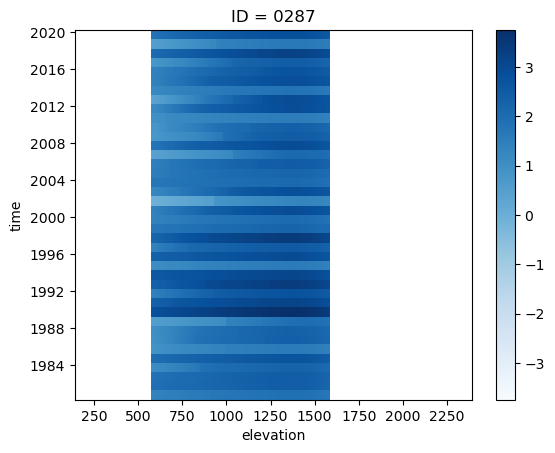

In [84]:
ds_winter_mb_elevband[0,:,:].plot(cmap='Blues')

In [85]:
# Get summer mass balance in elevation bands

# Accumulate monthly data only for months from May to September
summer_months = [5, 6, 7, 8, 9]

ds_summer_mb_elevband = grouped.map(select_sum, args=(summer_months,))

hyd_yr_dates = pd.date_range('1980-10-01', periods=len(ds_summer_mb_elevband['hyd_year']), freq='AS-OCT')

ds_summer_mb_elevband = ds_summer_mb_elevband.assign_coords(time=('hyd_year', hyd_yr_dates))

ds_summer_mb_elevband = ds_summer_mb_elevband.swap_dims({'hyd_year': 'time'})

ds_summer_mb_elevband = ds_summer_mb_elevband.drop_vars('hyd_year')

In [86]:
ds_summer_mb_elevband

<xarray.DataArray (ID: 32, time: 40, elevation: 225)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) int64 145 155 165 175 185 ... 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time       (time) datetime64[ns] 1980-10-01 1981-10-01 ... 2019-10-01

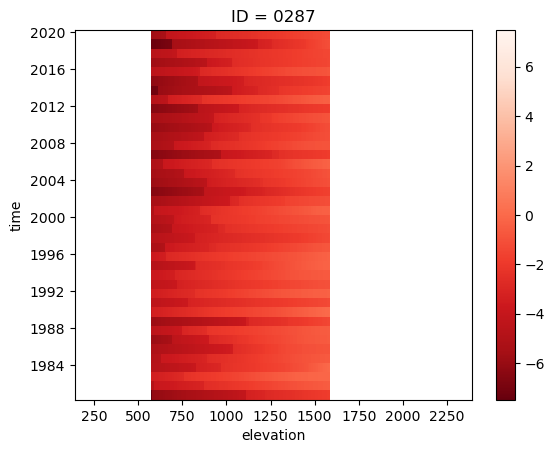

In [88]:
ds_summer_mb_elevband[0,:,:].plot(cmap='Reds_r')

### Combine annual and seasonal elevation-band mass balance in dataset

In [89]:
# Combine the DataArrays into a single dataset
ds_mb_elev_band = xr.Dataset({
    'mb_annual': ds_annual_mb_elevband,  
    'mb_winter': ds_winter_mb_elevband,  
    'mb_summer': ds_summer_mb_elevband
})

ds_mb_elev_band.attrs['Model'] = 'GloGEM'


In [90]:
ds_mb_elev_band

<xarray.Dataset>
Dimensions:    (time: 40, elevation: 225, ID: 32)
Coordinates:
  * time       (time) datetime64[ns] 1980-10-01 1981-10-01 ... 2019-10-01
  * elevation  (elevation) int64 145 155 165 175 185 ... 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
    mb_winter  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
    mb_summer  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Model:    GloGEM

In [91]:
filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

#ds_mb_elev_band.to_netcdf(filepath_save + 'GloGEM_annual_seasonal_mb_elev_band.nc')

## OGGM

### Elevation-band monthly mass balance

In [46]:
filepath_oggm_elevband = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/oggm_unprocessed/'

# Data structure:
# Dimensions: time: 720 elevation: 98
# Coordinates: time (time) datetime64[ns] 1960-01-01 ... 2019-12-01
#              elevation (elevation) int64 615 625 635 645 ... 1565 1575 1585
# Data variables: massbalance (time, elevation) float64 ...
#                 bin_area (elevation) float64 ...

# Each file has name RGI60-08.0XXXX 
# Attributes massbalance:
#     name:     Monthly mass balance
#     unit:     kg m-2 month-1,

files = [os.path.join(filepath_oggm_elevband, filename) for filename in os.listdir(filepath_oggm_elevband) if filename.startswith('RGI60-08.')]

rho = 860


In [47]:
# Initialize a list to hold DataArrays
massbalance_list = []
all_elevations = set()  # Set to store all unique elevation values

for file in files:
    # Extract ID from the filename using regex to capture the four-digit ID before the '.nc'
    glacier_id_match = re.search(r'(\d{4})\.nc$', os.path.basename(file))

    if glacier_id_match:
        glacier_id = glacier_id_match.group(1)

#for file in files:
    # Extract ID from the filename (assuming the ID is the part of the filename after the last '.')
 #   glacier_id = file.split('.')[-1]
    
        # Open the NetCDF file and select the 'massbalance' Data variable
        with xr.open_dataset(file) as ds:
            massbalance_da = ds['massbalance']
        
            # Store the elevation values from this file
            all_elevations.update(massbalance_da['elevation'].values.tolist())
        
            # Assign the ID as a new coordinate on the DataArray
            massbalance_da = massbalance_da.assign_coords(ID=glacier_id)
        
            # Append the DataArray to the list
            massbalance_list.append(massbalance_da.expand_dims('ID'))

# Convert the set of all elevations to a sorted list
all_elevations = sorted(list(all_elevations))

# Combine all the DataArrays into one Dataset
ds_monthly_mb_elevband_ = xr.combine_by_coords(massbalance_list, join='outer')

# Reindex the 'elevation' dimension to encompass all unique elevation values with NaN filling
ds_monthly_mb_elevband_ = ds_monthly_mb_elevband_.reindex(elevation=all_elevations, fill_value=np.nan)

ds_monthly_mb_elevband_['massbalance_mwe'] = ds_monthly_mb_elevband_['massbalance']/rho

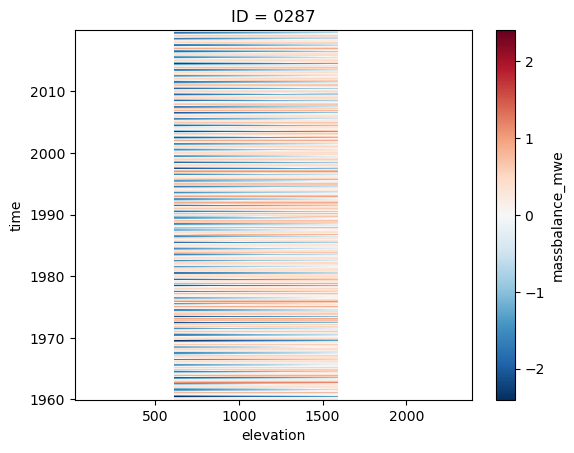

In [49]:
ds_monthly_mb_elevband_.massbalance_mwe[0,:,:].plot()

In [50]:
ds_monthly_mb_elevband_

<xarray.Dataset>
Dimensions:          (time: 720, elevation: 237, ID: 32)
Coordinates:
  * time             (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * elevation        (elevation) int64 25 35 45 55 65 ... 2355 2365 2375 2385
  * ID               (ID) <U4 '0287' '0295' '0434' ... '2963' '2966' '2969'
Data variables:
    massbalance      (ID, time, elevation) float64 nan nan nan ... nan nan nan
    massbalance_mwe  (ID, time, elevation) float64 nan nan nan ... nan nan nan

In [51]:
# Get dataarray of mass_balance_mwe

ds_monthly_mb_elevband = ds_monthly_mb_elevband_.massbalance_mwe.copy()

In [54]:
ds_monthly_mb_elevband

<xarray.DataArray 'massbalance_mwe' (ID: 32, time: 720, elevation: 237)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * elevation  (elevation) int64 25 35 45 55 65 75 ... 2345 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'

In [57]:
# Save monthly elevation-band mass balance as dataset

ds_monthly_mb_elevband_save = ds_monthly_mb_elevband.to_dataset(name='mb_monthly')

filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

#ds_monthly_mb_elevband_save.to_netcdf(filepath_save + 'OGGM_monthly_mb_elev_band.nc')

### Annual mass balance in each elevation band

In [15]:
ds_sliced = ds_monthly_mb_elevband.isel(time=slice(9, -3))

# Count nan per 12 month window
non_nan_count = ds_sliced.coarsen(time=12, boundary='trim').count()

# Aggregate mass balance for each year (12 months)
ds_annual_mb_elevband = ds_sliced.coarsen(time=12, boundary='trim').sum()

# Insert nan for non-existing elevation bands
ds_annual_mb_elevband = ds_annual_mb_elevband.where(non_nan_count == 12)

# Set hydrological years
hydro_years = pd.date_range(start='1961', end='2020', freq='AS-OCT')

# Set time to hydrological year
ds_annual_mb_elevband['time'] = hydro_years
ds_annual_mb_elevband = ds_annual_mb_elevband.assign_coords(time=hydro_years)

In [16]:
ds_annual_mb_elevband

<xarray.DataArray 'massbalance_mwe' (ID: 32, time: 59, elevation: 237)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2019-10-01
  * elevation  (elevation) int64 25 35 45 55 65 75 ... 2345 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'

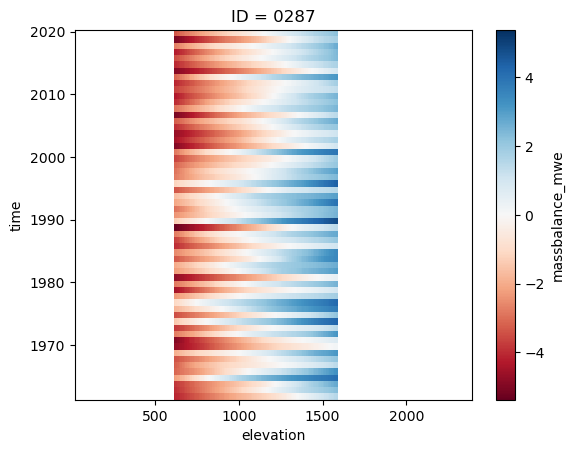

In [18]:
ds_annual_mb_elevband[0,:,:].plot(cmap='RdBu')

### Seasonal mass balance in each elevation band

In [33]:
# Add hydrological year as coordinate in monthly mb dataset
def hydro_year(time):
    year = time.dt.year
    month = time.dt.month
    return year.where(month < 10, year + 1)

# Add a 'hydro_year' coordinate to the dataset
ds_monthly_mb_elevband['hyd_year'] = hydro_year(ds_monthly_mb_elevband['time'])

ds_monthly_mb_elevband_sliced = ds_monthly_mb_elevband.isel(time=slice(9, -3))

# Group by hydrological year
grouped = ds_monthly_mb_elevband_sliced.groupby('hyd_year')


In [34]:
def select_sum(group, months):
    selected_group = group.sel(time=group['time.month'].isin(months))
    non_nan_count = selected_group.count(dim='time')
    summed_group = selected_group.sum(dim='time')
    return summed_group.where(non_nan_count >= 1)


In [35]:
# Get winter mass balance in elevation bands

# Accumulate monthly data only for months from October to April
winter_months = [10, 11, 12, 1, 2, 3, 4]

ds_winter_mb_elevband = grouped.map(select_sum, args=(winter_months,))

hyd_yr_dates = pd.date_range('1961-10-01', periods=len(ds_winter_mb_elevband['hyd_year']), freq='AS-OCT')

ds_winter_mb_elevband = ds_winter_mb_elevband.assign_coords(time=('hyd_year', hyd_yr_dates))

ds_winter_mb_elevband = ds_winter_mb_elevband.swap_dims({'hyd_year': 'time'})

ds_winter_mb_elevband = ds_winter_mb_elevband.drop_vars('hyd_year')

In [36]:
ds_winter_mb_elevband

<xarray.DataArray 'massbalance_mwe' (ID: 32, time: 59, elevation: 237)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) int64 25 35 45 55 65 75 ... 2345 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2019-10-01

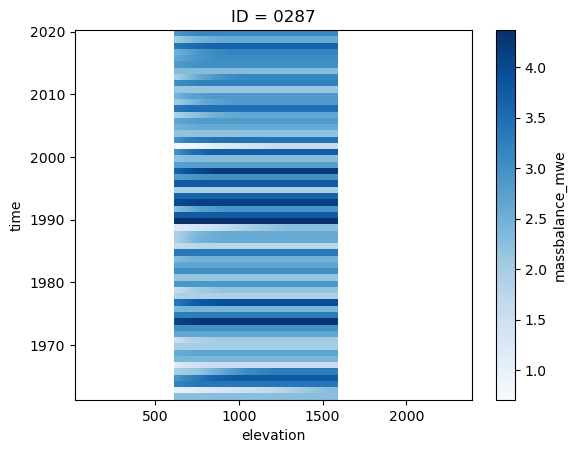

In [37]:
ds_winter_mb_elevband[0,:,:].plot(cmap='Blues')

In [38]:
# Get summer mass balance in elevation bands

# Accumulate monthly data only for months from May to September
summer_months = [5, 6, 7, 8, 9]

ds_summer_mb_elevband = grouped.map(select_sum, args=(summer_months,))

hyd_yr_dates = pd.date_range('1961-10-01', periods=len(ds_summer_mb_elevband['hyd_year']), freq='AS-OCT')

ds_summer_mb_elevband = ds_summer_mb_elevband.assign_coords(time=('hyd_year', hyd_yr_dates))

ds_summer_mb_elevband = ds_summer_mb_elevband.swap_dims({'hyd_year': 'time'})

ds_summer_mb_elevband = ds_summer_mb_elevband.drop_vars('hyd_year')

In [39]:
ds_summer_mb_elevband

<xarray.DataArray 'massbalance_mwe' (ID: 32, time: 59, elevation: 237)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) int64 25 35 45 55 65 75 ... 2345 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2019-10-01

## Combine annual and seasonal elevation-band mb in dataset

In [41]:
# Combine the DataArrays into a single dataset
ds_mb_elev_band = xr.Dataset({
    'mb_annual': ds_annual_mb_elevband,  
    'mb_winter': ds_winter_mb_elevband,  
    'mb_summer': ds_summer_mb_elevband
})

ds_mb_elev_band.attrs['Model'] = 'OGGM'


In [42]:
ds_mb_elev_band

<xarray.Dataset>
Dimensions:    (time: 59, elevation: 237, ID: 32)
Coordinates:
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2019-10-01
  * elevation  (elevation) int64 25 35 45 55 65 75 ... 2345 2355 2365 2375 2385
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
    mb_winter  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
    mb_summer  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Model:    OGGM

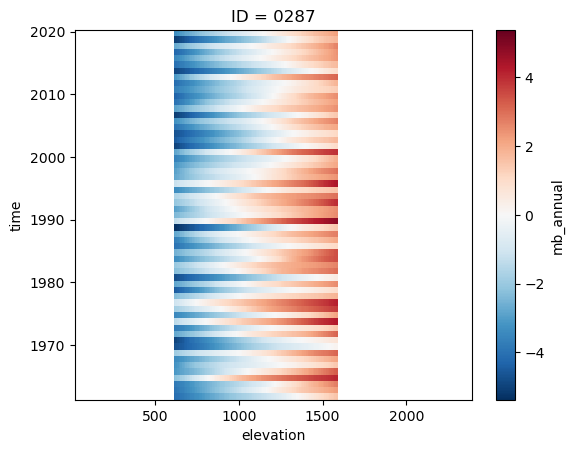

In [43]:
ds_mb_elev_band.mb_annual[0,:,:].plot()

In [44]:
filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

ds_mb_elev_band.to_netcdf(filepath_save + 'OGGM_annual_seasonal_mb_elev_band.nc')

## PyGEM

### Elevation-band monthly mass balance

In [186]:
filepath_pygem_elevband = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/pygem_unprocessed/'

fn = '8.02918_ERA5_MCMC_ba0_1sets_1960_2022_binned.nc'

with xr.open_dataset(filepath_pygem_elevband + fn) as test_out:
    test = test_out

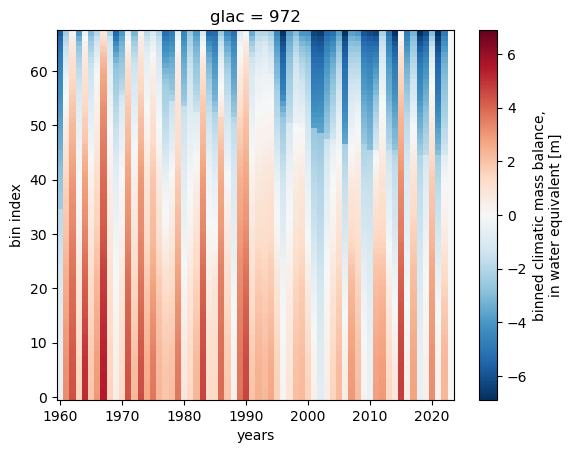

In [187]:
test.bin_massbalclim_annual[0,:,:].plot()

In [188]:
test.bin_distance.values

array([[    0.,   154.,   308.,   462.,   616.,   770.,   924.,  1078.,
         1232.,  1386.,  1540.,  1694.,  1848.,  2002.,  2156.,  2310.,
         2464.,  2618.,  2772.,  2926.,  3080.,  3234.,  3388.,  3542.,
         3696.,  3850.,  4004.,  4158.,  4312.,  4466.,  4620.,  4774.,
         4928.,  5082.,  5236.,  5390.,  5544.,  5698.,  5852.,  6006.,
         6160.,  6314.,  6468.,  6622.,  6776.,  6930.,  7084.,  7238.,
         7392.,  7546.,  7700.,  7854.,  8008.,  8162.,  8316.,  8470.,
         8624.,  8778.,  8932.,  9086.,  9240.,  9394.,  9548.,  9702.,
         9856., 10010., 10164., 10318.]])

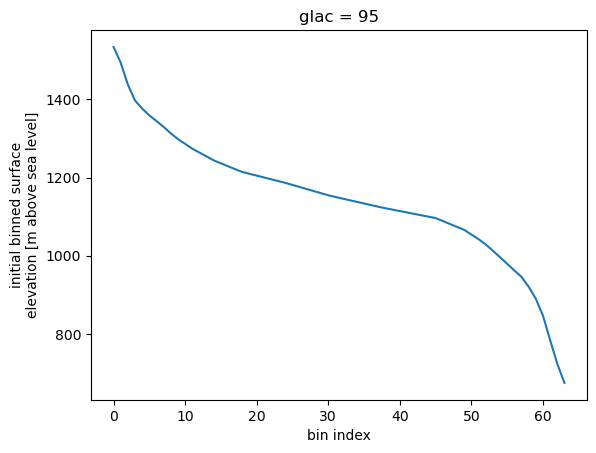

In [102]:
test.bin_surface_h_initial[0,:].plot()

In [101]:
# Folder containing the NetCDF files
#filepath_pygem_elevband = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/pygem_unprocessed/'

# Prepare a dictionary to hold the mass balance DataArrays keyed by glacier ID
# Prepare a list to hold the mass balance DataArrays
#massbal_list = []

# List all the NetCDF files in the folder
#netcdf_files = [f for f in os.listdir(filepath_pygem_elevband) if re.match(r"8\.0\d{4}_ERA5_MCMC_ba0_1sets_1960_2022_binned\.nc", f)]

# Process each NetCDF file
# Process each NetCDF file
# Process each NetCDF file
#for filename in netcdf_files:
    # Extract the ID from the filename
#    id_match = re.search(r"8\.0(\d{4})_ERA5_MCMC_ba0_1sets_1960_2022_binned\.nc", filename)
#    if id_match:
#        glacier_id = id_match.group(1)
        
        # Load the NetCDF file
#        ds = xr.open_dataset(os.path.join(filepath_pygem_elevband, filename))
        
        # Round 'bin_surface_h_initial' to one decimal place and convert to a NumPy array
#        elevation_one_decimal = np.round(ds['bin_surface_h_initial'].isel(glac=0).values, decimals=1)

        #print(glacier_id)
        #print((np.unique(elevation_one_decimal).shape))
        #print(elevation_one_decimal.shape)
        
        # Select the 'bin_massbalclim_monthly' variable and ensure it is a 2D data structure
#        massbal = ds['bin_massbalclim_monthly'].isel(glac=0)

        # Make sure 'time' is in the 'YYYY-MM-01' format
#        time_coords = pd.to_datetime(massbal['time'].dt.strftime('%Y-%m-01'))

#        massbal_expanded = np.expand_dims(massbal.values, axis=0)  # Adds an extra dimension

        # Create the new DataArray with 'glacier_id', 'time', and 'elevation' as dimensions
#        new_massbal = xr.DataArray(
#            data=massbal_expanded,  # use the underlying data array
#            coords={'ID': [glacier_id], 'elevation': elevation_one_decimal, 'time': time_coords},
#            dims=('ID', 'elevation', 'time'),
#            name='massbal'
#        )
        
        # Add the new DataArray to the list
#        massbal_list.append(new_massbal)
        

In [150]:
massbal_list = []

for filename in netcdf_files:
    id_match = re.search(r"8\.0(\d{4})_ERA5_MCMC_ba0_1sets_1960_2022_binned\.nc", filename)
    if id_match:
        glacier_id = id_match.group(1)
        ds = xr.open_dataset(os.path.join(filepath_pygem_elevband, filename))
        elevation_rounded = np.round(ds['bin_surface_h_initial'].isel(glac=0).values, decimals=1)
        
        # Replace the 'bin' coordinate with the rounded elevation values
        massbal = ds['bin_massbalclim_monthly'].isel(glac=0).assign_coords(bin=elevation_rounded).rename({'bin': 'elevation'})
        
        time_coords = pd.to_datetime(massbal['time'].dt.strftime('%Y-%m-01'))
        
        # Define elevation bins that increment by 10m, and make sure the first bin edge is a multiple of 10.
        elevation_bin_edges = np.arange(
            start=np.floor(elevation_rounded.min() / 10) * 10,
            stop=np.ceil(elevation_rounded.max() / 10) * 10 + 1,
            step=10
            )
 
        elevation_bin_midpoints = (elevation_bin_edges[:-1] + elevation_bin_edges[1:]) / 2
        
        # Group by elevation bins and then take the mean
        massbal_coarsened = massbal.groupby_bins('elevation', bins=elevation_bin_edges, right=False).mean()

        massbal_expanded = np.expand_dims(massbal_coarsened.values, axis=0)  # Adds an extra dimension
        
        # Create the new DataArray with 'glacier_id', 'time', and 'elevation' as dimensions, using midpoint of bins
        new_massbal_coarsened = xr.DataArray(
            data=massbal_expanded, 
            coords={'ID': [glacier_id], 'elevation': elevation_bin_midpoints, 'time': time_coords},
            dims=('ID', 'elevation', 'time'),
            name='massbal'
        )
        
        massbal_list.append(new_massbal_coarsened)

concatenated_dataset = xr.concat(massbal_list, dim='ID')

ds_monthly_mb_elevband = concatenated_dataset.transpose('ID', 'time', 'elevation')


In [152]:
ds_monthly_mb_elevband.time

<xarray.DataArray 'time' (time: 756)>
array(['1960-01-01T00:00:00.000000000', '1960-02-01T00:00:00.000000000',
       '1960-03-01T00:00:00.000000000', ..., '2022-10-01T00:00:00.000000000',
       '2022-11-01T00:00:00.000000000', '2022-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2022-12-01

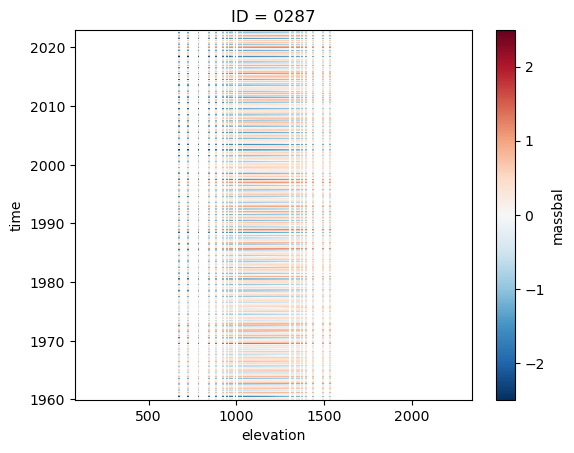

In [151]:
ds_monthly_mb_elevband[0,:,:].plot()

In [153]:
# Save monthly elevation-band mass balance as dataset

ds_monthly_mb_elevband_save = ds_monthly_mb_elevband.to_dataset(name='mb_monthly')

filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

ds_monthly_mb_elevband_save.to_netcdf(filepath_save + 'PyGEM_monthly_mb_elev_band.nc')

### Annual mass balance in each elevation band

In [163]:
ds_sliced = ds_monthly_mb_elevband.isel(time=slice(9, -3))

# Count nan per 12 month window
non_nan_count = ds_sliced.coarsen(time=12, boundary='trim').count()

# Aggregate mass balance for each year (12 months)
ds_annual_mb_elevband = ds_sliced.coarsen(time=12, boundary='trim').sum()

# Insert nan for non-existing elevation bands
ds_annual_mb_elevband = ds_annual_mb_elevband.where(non_nan_count == 12)

# Set hydrological years
hydro_years = pd.date_range(start='1961', end='2023', freq='AS-OCT')

# Set time to hydrological year
ds_annual_mb_elevband['time'] = hydro_years
ds_annual_mb_elevband = ds_annual_mb_elevband.assign_coords(time=hydro_years)

In [164]:
ds_annual_mb_elevband

<xarray.DataArray 'massbal' (ID: 32, time: 62, elevation: 226)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) float64 85.0 95.0 105.0 ... 2.325e+03 2.335e+03
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2022-10-01
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'

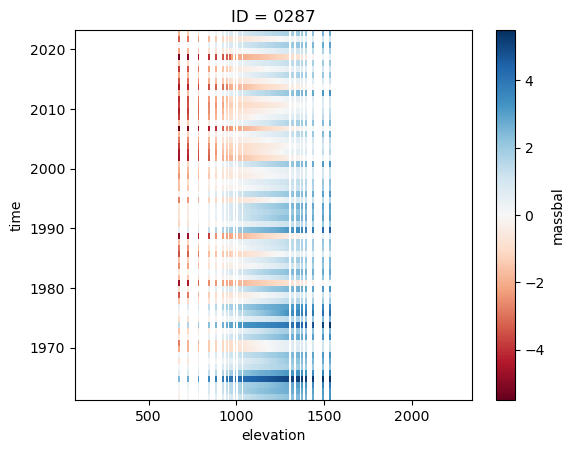

In [166]:
ds_annual_mb_elevband[0,:,:].plot(cmap='RdBu')

### Seasonal mass balance in each elevation band

In [167]:
# Add hydrological year as coordinate in monthly mb dataset
def hydro_year(time):
    year = time.dt.year
    month = time.dt.month
    return year.where(month < 10, year + 1)

# Add a 'hydro_year' coordinate to the dataset
ds_monthly_mb_elevband['hyd_year'] = hydro_year(ds_monthly_mb_elevband['time'])

ds_monthly_mb_elevband_sliced = ds_monthly_mb_elevband.isel(time=slice(9, -3))

# Group by hydrological year
grouped = ds_monthly_mb_elevband_sliced.groupby('hyd_year')


In [168]:
def select_sum(group, months):
    selected_group = group.sel(time=group['time.month'].isin(months))
    non_nan_count = selected_group.count(dim='time')
    summed_group = selected_group.sum(dim='time')
    return summed_group.where(non_nan_count >= 1)


In [169]:
# Get winter mass balance in elevation bands

# Accumulate monthly data only for months from October to April
winter_months = [10, 11, 12, 1, 2, 3, 4]

ds_winter_mb_elevband = grouped.map(select_sum, args=(winter_months,))

hyd_yr_dates = pd.date_range('1961-10-01', periods=len(ds_winter_mb_elevband['hyd_year']), freq='AS-OCT')

ds_winter_mb_elevband = ds_winter_mb_elevband.assign_coords(time=('hyd_year', hyd_yr_dates))

ds_winter_mb_elevband = ds_winter_mb_elevband.swap_dims({'hyd_year': 'time'})

ds_winter_mb_elevband = ds_winter_mb_elevband.drop_vars('hyd_year')

In [170]:
ds_winter_mb_elevband

<xarray.DataArray 'massbal' (ID: 32, time: 62, elevation: 226)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) float64 85.0 95.0 105.0 ... 2.325e+03 2.335e+03
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2022-10-01

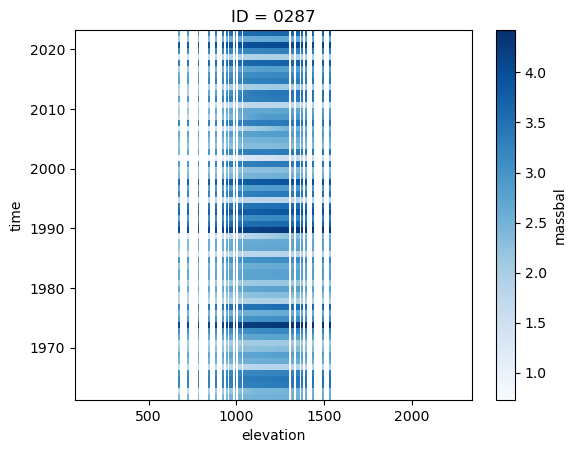

In [171]:
ds_winter_mb_elevband[0,:,:].plot(cmap='Blues')

In [172]:
# Get summer mass balance in elevation bands

# Accumulate monthly data only for months from May to September
summer_months = [5, 6, 7, 8, 9]

ds_summer_mb_elevband = grouped.map(select_sum, args=(summer_months,))

hyd_yr_dates = pd.date_range('1961-10-01', periods=len(ds_summer_mb_elevband['hyd_year']), freq='AS-OCT')

ds_summer_mb_elevband = ds_summer_mb_elevband.assign_coords(time=('hyd_year', hyd_yr_dates))

ds_summer_mb_elevband = ds_summer_mb_elevband.swap_dims({'hyd_year': 'time'})

ds_summer_mb_elevband = ds_summer_mb_elevband.drop_vars('hyd_year')

In [173]:
ds_summer_mb_elevband

<xarray.DataArray 'massbal' (ID: 32, time: 62, elevation: 226)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * elevation  (elevation) float64 85.0 95.0 105.0 ... 2.325e+03 2.335e+03
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2022-10-01

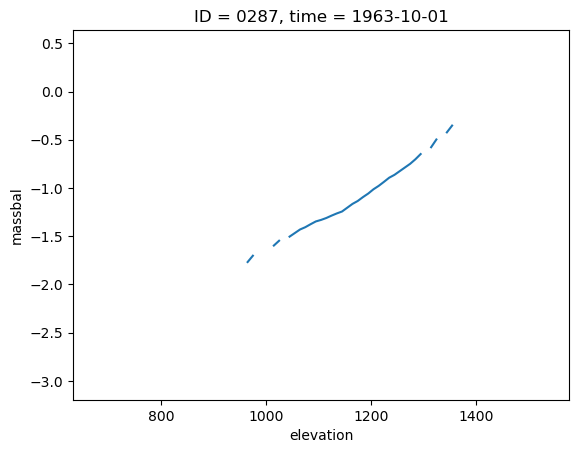

In [180]:
ds_summer_mb_elevband[0,2,:].plot()#(cmap='Reds')

## Combine annual and seasonal elevation-band mb in dataset

In [189]:
# Combine the DataArrays into a single dataset
ds_mb_elev_band = xr.Dataset({
    'mb_annual': ds_annual_mb_elevband,  
    'mb_winter': ds_winter_mb_elevband,  
    'mb_summer': ds_summer_mb_elevband
})

ds_mb_elev_band.attrs['Model'] = 'PyGEM'


In [190]:
ds_mb_elev_band

<xarray.Dataset>
Dimensions:    (elevation: 226, time: 62, ID: 32)
Coordinates:
  * elevation  (elevation) float64 85.0 95.0 105.0 ... 2.325e+03 2.335e+03
  * time       (time) datetime64[ns] 1961-10-01 1962-10-01 ... 2022-10-01
  * ID         (ID) <U4 '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_annual  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
    mb_winter  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
    mb_summer  (ID, time, elevation) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Model:    PyGEM

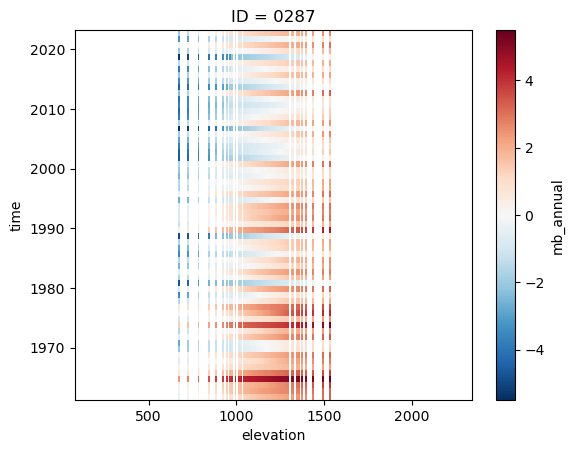

In [191]:
ds_mb_elev_band.mb_annual[0,:,:].plot()

In [192]:
filepath_save = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/'

ds_mb_elev_band.to_netcdf(filepath_save + 'PyGEM_annual_seasonal_mb_elev_band.nc')